<a id='Top'></a>

# MultiSurv results by cancer type<a class='tocSkip'></a>

C-index value results for each cancer type of the best MultiSurv model trained on all-cancer data.

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext watermark

import sys
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch

# Make modules in "src" dir visible
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(os.path.join(project_dir, 'src'))

import dataset
from model import Model
import utils

matplotlib.style.use('multisurv.mplstyle')

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-model" data-toc-modified-id="Load-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load model</a></span></li><li><span><a href="#Evaluate" data-toc-modified-id="Evaluate-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Evaluate</a></span></li><li><span><a href="#Result-graph" data-toc-modified-id="Result-graph-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Result graph</a></span><ul class="toc-item"><li><span><a href="#Save-to-files" data-toc-modified-id="Save-to-files-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Save to files</a></span></li></ul></li><li><span><a href="#Metric-correlation-with-other-attributes" data-toc-modified-id="Metric-correlation-with-other-attributes-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Metric correlation with other attributes</a></span><ul class="toc-item"><li><span><a href="#Collect-feature-representations" data-toc-modified-id="Collect-feature-representations-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Collect feature representations</a></span></li><li><span><a href="#Compute-dispersion-and-add-to-selected-metric-table" data-toc-modified-id="Compute-dispersion-and-add-to-selected-metric-table-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Compute dispersion and add to selected metric table</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Plot</a></span></li></ul></li></ul></div>

In [2]:
DATA = utils.INPUT_DATA_DIR
MODELS = utils.TRAINED_MODEL_DIR

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load model

In [3]:
dataloaders = utils.get_dataloaders(
    data_location=DATA,
    labels_file='../data/labels.tsv',
    modalities=['clinical', 'mRNA'],
#     exclude_patients=exclude_cancers,
    return_patient_id=True
)

Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 1092

Batch size: 128


In [4]:
multisurv = Model(dataloaders=dataloaders, device=device)
multisurv.load_weights(os.path.join(MODELS, 'clinical_mRNA_lr0.005_epoch43_acc0.81.pth'))

Instantiating MultiSurv model...
Load model weights:
/mnt/dataA/multisurv_models/clinical_mRNA_lr0.005_epoch43_acc0.81.pth


# Evaluate

In [5]:
def get_patients_with(cancer_type, split_group='test'):
    labels = pd.read_csv('../data/labels.tsv', sep='\t')
    cancer_labels = labels[labels['project_id'] == cancer_type]
    group_cancer_labels = cancer_labels[cancer_labels['group'] == split_group]

    return list(group_cancer_labels['submitter_id'])

In [6]:
%%time

results = {}
minimum_n_patients = 0

cancer_types = pd.read_csv('../data/labels.tsv', sep='\t').project_id.unique()

for i, cancer_type in enumerate(cancer_types):
    print('-' * 44)
    print(' ' * 17, f'{i + 1}.', cancer_type)
    print('-' * 44)

    patients = get_patients_with(cancer_type)
    if len(patients) < minimum_n_patients:
        continue
    
    exclude_patients = [p for p in dataloaders['test'].dataset.patient_ids
                        if not p in patients]

    data = utils.get_dataloaders(
        data_location=DATA,
        labels_file='../data/labels.tsv',
        modalities=['clinical', 'mRNA'],
        exclude_patients=exclude_patients,
        return_patient_id=True
    )['test'].dataset

    results[cancer_type] = utils.Evaluation(model=multisurv, dataset=data, device=device)
    results[cancer_type].run_bootstrap()
    print()
print()
print()

--------------------------------------------
                  1. SARC
--------------------------------------------
Keeping 8880 patient(s) not in exclude list.
Keeping 1109 patient(s) not in exclude list.
Keeping 26 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 26

Batch size: 128
Collect patient predictions: 26/26

Bootstrap
---------
1000/1000

--------------------------------------------
                  2. MESO
--------------------------------------------
Keeping 8880 patient(s) not in exclude list.
Keeping 1109 patient(s) not in exclude list.
Keeping 8 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 8

Batch size: 128
Collect patient predictions: 8/8

Bootstrap
---------
1000/1000

--------------------------------------------
                  3. ACC
--------------------------------------------
Keeping 888

/home/luis/Documents/Work/2018_Postdoc_BioQuant/Projects/multisurv/src/evaluation.py:332: UserWarning: Skipped 105 bootstraps (No admissable pairs in the dataset.).
  f'Skipped {skipped} bootstraps ({err}).')


Keeping 17 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 17

Batch size: 128
Collect patient predictions: 17/17

Bootstrap
---------
1000/1000

--------------------------------------------
                  5. LGG
--------------------------------------------


/home/luis/Documents/Work/2018_Postdoc_BioQuant/Projects/multisurv/src/evaluation.py:332: UserWarning: Skipped 71 bootstraps (No admissable pairs in the dataset.).
  f'Skipped {skipped} bootstraps ({err}).')


Keeping 8880 patient(s) not in exclude list.
Keeping 1109 patient(s) not in exclude list.
Keeping 50 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 50

Batch size: 128
Collect patient predictions: 50/50

Bootstrap
---------
1000/1000

--------------------------------------------
                  6. THCA
--------------------------------------------
Keeping 8880 patient(s) not in exclude list.
Keeping 1109 patient(s) not in exclude list.
Keeping 50 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 50

Batch size: 128
Collect patient predictions: 50/50

Bootstrap
---------
1000/1000

--------------------------------------------
                  7. CHOL
--------------------------------------------


/home/luis/Documents/Work/2018_Postdoc_BioQuant/Projects/multisurv/src/evaluation.py:332: UserWarning: Skipped 37 bootstraps (No admissable pairs in the dataset.).
  f'Skipped {skipped} bootstraps ({err}).')


Keeping 8880 patient(s) not in exclude list.
Keeping 1109 patient(s) not in exclude list.
Keeping 5 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 5

Batch size: 128
Collect patient predictions: 5/5

Bootstrap
---------
1000/1000

--------------------------------------------
                  8. KIRC
--------------------------------------------
Keeping 8880 patient(s) not in exclude list.
Keeping 1109 patient(s) not in exclude list.


/home/luis/Documents/Work/2018_Postdoc_BioQuant/Projects/multisurv/src/evaluation.py:332: UserWarning: Skipped 2 bootstraps (No admissable pairs in the dataset.).
  f'Skipped {skipped} bootstraps ({err}).')


Keeping 53 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 53

Batch size: 128
Collect patient predictions: 53/53

Bootstrap
---------
1000/1000

--------------------------------------------
                  9. BRCA
--------------------------------------------
Keeping 8880 patient(s) not in exclude list.
Keeping 1109 patient(s) not in exclude list.
Keeping 108 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 108

Batch size: 128
Collect patient predictions: 108/108

Bootstrap
---------
1000/1000

--------------------------------------------
                  10. OV
--------------------------------------------
Keeping 8880 patient(s) not in exclude list.
Keeping 1109 patient(s) not in exclude list.
Keeping 57 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 

/home/luis/Documents/Work/2018_Postdoc_BioQuant/Projects/multisurv/src/evaluation.py:332: UserWarning: Skipped 117 bootstraps (No admissable pairs in the dataset.).
  f'Skipped {skipped} bootstraps ({err}).')


Keeping 8880 patient(s) not in exclude list.
Keeping 1109 patient(s) not in exclude list.
Keeping 8 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 8

Batch size: 128
Collect patient predictions: 8/8

Bootstrap
---------
1000/1000

--------------------------------------------
                  16. THYM
--------------------------------------------


/home/luis/Documents/Work/2018_Postdoc_BioQuant/Projects/multisurv/src/evaluation.py:332: UserWarning: Skipped 88 bootstraps (No admissable pairs in the dataset.).
  f'Skipped {skipped} bootstraps ({err}).')


Keeping 8880 patient(s) not in exclude list.
Keeping 1109 patient(s) not in exclude list.
Keeping 12 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 12

Batch size: 128
Collect patient predictions: 12/12


--------------------------------------------
                  17. TGCT
--------------------------------------------
Keeping 8880 patient(s) not in exclude list.
Keeping 1109 patient(s) not in exclude list.
Keeping 13 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 13

Batch size: 128
Collect patient predictions: 13/13


--------------------------------------------
                  18. LUSC
--------------------------------------------
Keeping 8880 patient(s) not in exclude list.
Keeping 1109 patient(s) not in exclude list.
Keeping 49 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset s

/home/luis/Documents/Work/2018_Postdoc_BioQuant/Projects/multisurv/src/evaluation.py:332: UserWarning: Skipped 161 bootstraps (No admissable pairs in the dataset.).
  f'Skipped {skipped} bootstraps ({err}).')


Keeping 8880 patient(s) not in exclude list.
Keeping 1109 patient(s) not in exclude list.
Keeping 54 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 54

Batch size: 128
Collect patient predictions: 54/54

Bootstrap
---------
1000/1000

--------------------------------------------
                  21. LAML
--------------------------------------------


/home/luis/Documents/Work/2018_Postdoc_BioQuant/Projects/multisurv/src/evaluation.py:332: UserWarning: Skipped 3 bootstraps (No admissable pairs in the dataset.).
  f'Skipped {skipped} bootstraps ({err}).')


Keeping 8880 patient(s) not in exclude list.
Keeping 1109 patient(s) not in exclude list.
Keeping 18 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 18

Batch size: 128
Collect patient predictions: 18/18

Bootstrap
---------
1000/1000

--------------------------------------------
                  22. STAD
--------------------------------------------
Keeping 8880 patient(s) not in exclude list.
Keeping 1109 patient(s) not in exclude list.
Keeping 43 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 43

Batch size: 128
Collect patient predictions: 43/43

Bootstrap
---------
1000/1000

--------------------------------------------
                  23. ESCA
--------------------------------------------
Keeping 8880 patient(s) not in exclude list.
Keeping 1109 patient(s) not in exclude list.
Keeping 18 patient(s) not in e

/home/luis/Documents/Work/2018_Postdoc_BioQuant/Projects/multisurv/src/evaluation.py:332: UserWarning: Skipped 7 bootstraps (No admissable pairs in the dataset.).
  f'Skipped {skipped} bootstraps ({err}).')


Keeping 8880 patient(s) not in exclude list.
Keeping 1109 patient(s) not in exclude list.
Keeping 52 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 52

Batch size: 128
Collect patient predictions: 52/52

Bootstrap
---------
1000/1000

--------------------------------------------
                  25. LIHC
--------------------------------------------
Keeping 8880 patient(s) not in exclude list.
Keeping 1109 patient(s) not in exclude list.
Keeping 37 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 37

Batch size: 128
Collect patient predictions: 37/37

Bootstrap
---------
1000/1000

--------------------------------------------
                  26. COAD
--------------------------------------------
Keeping 8880 patient(s) not in exclude list.
Keeping 1109 patient(s) not in exclude list.
Keeping 45 patient(s) not in e

/home/luis/Documents/Work/2018_Postdoc_BioQuant/Projects/multisurv/src/evaluation.py:332: UserWarning: Skipped 81 bootstraps (No admissable pairs in the dataset.).
  f'Skipped {skipped} bootstraps ({err}).')


Keeping 29 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 29

Batch size: 128
Collect patient predictions: 29/29

Bootstrap
---------
1000/1000

--------------------------------------------
                  32. PCPG
--------------------------------------------
Keeping 8880 patient(s) not in exclude list.
Keeping 1109 patient(s) not in exclude list.
Keeping 18 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 18

Batch size: 128
Collect patient predictions: 18/18

Bootstrap
---------
1000/1000

--------------------------------------------
                  33. BLCA
--------------------------------------------
Keeping 8880 patient(s) not in exclude list.


/home/luis/Documents/Work/2018_Postdoc_BioQuant/Projects/multisurv/src/evaluation.py:332: UserWarning: Skipped 116 bootstraps (No admissable pairs in the dataset.).
  f'Skipped {skipped} bootstraps ({err}).')


Keeping 1109 patient(s) not in exclude list.
Keeping 40 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 40

Batch size: 128
Collect patient predictions: 40/40

Bootstrap
---------
1000/1000



CPU times: user 6min 55s, sys: 19.5 s, total: 7min 14s
Wall time: 6min 42s


In [7]:
%%time

data = utils.get_dataloaders(
    data_location=DATA,
    labels_file='../data/labels.tsv',
    modalities=['clinical', 'mRNA'],
    return_patient_id=True
)['test'].dataset

results['All'] = utils.Evaluation(model=multisurv, dataset=data, device=device)
results['All'].run_bootstrap()
print()

Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 1092

Batch size: 128
Collect patient predictions: 1092/1092

Bootstrap
---------
1000/1000

CPU times: user 4min 3s, sys: 8.33 s, total: 4min 11s
Wall time: 5min 4s


In order to avoid very __noisy values__, establish a __minimum threshold__ for the number of patients in each given cancer type.

In [8]:
minimum_n_patients = 20

In [9]:
cancer_types = pd.read_csv('../data/labels.tsv', sep='\t').project_id.unique()
selected_cancer_types = ['All']

print('-' * 40)
print(' Cancer     Ctd      IBS     # patients')
print('-' * 40)
for cancer_type in sorted(list(cancer_types)):
    patients = get_patients_with(cancer_type)
    if len(patients) > minimum_n_patients:
        selected_cancer_types.append(cancer_type)
        ctd = str(round(results[cancer_type].c_index_td, 3))
        ibs = str(round(results[cancer_type].ibs, 3))

        message = '  ' + cancer_type
        message += ' ' * (11 - len(message)) + ctd
        message += ' ' * (20 - len(message)) + ibs
        message += ' ' * (32 - len(message)) + str(len(patients))
        print(message)
#         print(' ' + cancer_type + ' ' * (10 - len(cancer_type)) + \
#               ctd + ' ' * (10 - len(ibs)) + ibs + ' ' * (13 - len(ctd)) \
#               + str(len(patients)))

----------------------------------------
 Cancer     Ctd      IBS     # patients
----------------------------------------
  BLCA     0.784    0.17        40
  BRCA     0.847    0.109       108
  CESC     0.86     0.15        30
  COAD     0.953    0.161       45
  GBM      0.65     0.109       58
  HNSC     0.715    0.225       52
  KIRC     0.78     0.146       53
  KIRP     0.959    0.066       29
  LGG      0.741    0.142       50
  LIHC     0.847    0.161       37
  LUAD     0.686    0.165       51
  LUSC     0.554    0.224       49
  OV       0.644    0.166       57
  PRAD     0.848    0.079       49
  SARC     0.589    0.265       26
  SKCM     0.773    0.142       45
  STAD     0.774    0.191       43
  THCA     0.988    0.045       50
  UCEC     0.658    0.088       54


In [10]:
def format_bootstrap_output(evaluator):
    results = evaluator.format_results()
    
    for metric in results:
        results[metric] = results[metric].split(' ')
        val = results[metric][0]
        ci_low, ci_high = results[metric][1].split('(')[1].split(')')[0].split('-')
        results[metric] = val, ci_low, ci_high
        results[metric] = [float(x) for x in results[metric]]
    
    return results

In [11]:
formatted_results = {}

# for cancer_type in results:
for cancer_type in sorted(selected_cancer_types):
    formatted_results[cancer_type] = format_bootstrap_output(results[cancer_type])

In [12]:
formatted_results

{'All': {'C-index': [0.818, 0.8, 0.835],
  'Ctd': [0.822, 0.805, 0.839],
  'IBS': [0.138, 0.127, 0.151],
  'INBLL': [0.425, 0.396, 0.463]},
 'BLCA': {'C-index': [0.776, 0.682, 0.88],
  'Ctd': [0.784, 0.691, 0.893],
  'IBS': [0.17, 0.134, 0.203],
  'INBLL': [0.513, 0.425, 0.589]},
 'BRCA': {'C-index': [0.845, 0.733, 0.937],
  'Ctd': [0.847, 0.735, 0.94],
  'IBS': [0.109, 0.066, 0.135],
  'INBLL': [0.35, 0.226, 0.421]},
 'CESC': {'C-index': [0.86, 0.721, 0.987],
  'Ctd': [0.86, 0.721, 0.983],
  'IBS': [0.15, 0.069, 0.205],
  'INBLL': [0.459, 0.256, 0.586]},
 'COAD': {'C-index': [0.944, 0.897, 0.983],
  'Ctd': [0.953, 0.917, 0.988],
  'IBS': [0.161, 0.066, 0.192],
  'INBLL': [0.51, 0.235, 0.626]},
 'GBM': {'C-index': [0.65, 0.572, 0.723],
  'Ctd': [0.65, 0.572, 0.723],
  'IBS': [0.109, 0.101, 0.205],
  'INBLL': [0.353, 0.328, 0.595]},
 'HNSC': {'C-index': [0.71, 0.599, 0.829],
  'Ctd': [0.715, 0.604, 0.835],
  'IBS': [0.225, 0.186, 0.262],
  'INBLL': [0.641, 0.552, 0.729]},
 'KIRC': {'C-i

# Result graph

Exclude cancer types with less than a chosen minimum number of patients, to avoid extremely noisy results.

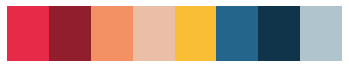

In [13]:
utils.plot.show_default_colors()

In [14]:
PLOT_SIZE = (15, 4)
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [15]:
def get_metric_results(metric, data):
    df = pd.DataFrame()
    df['Cancer type'] = data.keys()

    val, err = [], []
    
    for cancer in formatted_results:
        values = formatted_results[cancer][metric]
        val.append(values[0])
        err.append((values[0] - values[1], values[2] - values[0]))

    df[metric] = val
    err = np.swapaxes(np.array(err), 1, 0)

    return df, err

In [16]:
def plot_results(metric, data, ci, y_lim=None, y_label=None, h_lines=[1, 0.5]):
    fig = plt.figure(figsize=PLOT_SIZE)
    ax = fig.add_subplot(1, 1, 1)
    for y in h_lines:
        ax.axhline(y, linestyle='--', color='grey')

    ax.bar(df['Cancer type'][:1], df[metric][:1], yerr=err[:, :1],
           align='center', ecolor=default_colors[0],
           alpha=0.5, capsize=5)
    ax.bar(df['Cancer type'][1:], df[metric][1:], yerr=err[:, 1:],
           align='center', color=default_colors[6], ecolor=default_colors[6],
           alpha=0.5, capsize=5)
    if y_lim is None:
        y_lim = (0, 1)
        
    ax.set_ylim(y_lim)
    ax.set_title('')
    ax.set_xlabel('Cancer types')
    if y_label is None:
        ax.set_ylabel(metric + ' (95% CI)')
    else:
        ax.set_ylabel(y_label)

    return fig

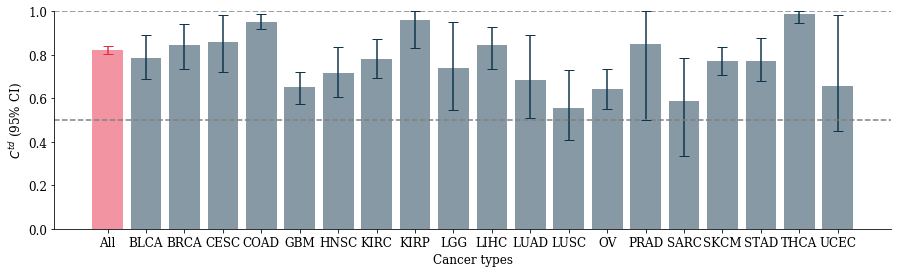

In [17]:
metric='Ctd'

df, err = get_metric_results(metric, formatted_results)
fig_ctd = plot_results(metric, df, err, y_label='$C^{td}$ (95% CI)')

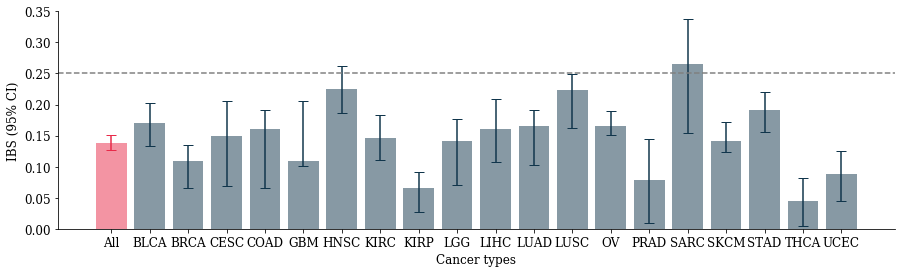

In [18]:
metric='IBS'

df, err = get_metric_results(metric, formatted_results)
fig_ibs = plot_results(metric, df, err, y_lim=(0, 0.35), y_label=None, h_lines=[0.25])

## Save to files

In [182]:
%%javascript

IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [183]:
pdf_file = nb_name.split('.ipynb')[0] + '_Ctd'
utils.plot.save_plot_for_figure(figure=fig_ctd, file_name=pdf_file) 

In [184]:
pdf_file = nb_name.split('.ipynb')[0] + '_IBS'
utils.plot.save_plot_for_figure(figure=fig_ibs, file_name=pdf_file) 

In [185]:
pdf_file = nb_name.split('.ipynb')[0] + '_INBLL'
utils.plot.save_plot_for_figure(figure=fig_inbll, file_name=pdf_file) 

# Watermark<a class='tocSkip'></a>

In [19]:
%watermark --iversions
%watermark -v
print()
%watermark -u -n

pandas     1.0.1
torch      1.4.0
numpy      1.18.1
matplotlib 3.1.2

CPython 3.6.7
IPython 7.11.1

last updated: Tue Jul 28 2020


[Top of the page](#Top)